In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import string

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
url = "https://raw.githubusercontent.com/AndersonJo/text-classification-tutorial/master/spam.csv"
data = pd.read_csv(url, encoding='latin-1', usecols=(0, 1), names=('class', 'text'), skiprows=1)
display(data.head())
display(data.groupby('class').describe())

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


text                                                               
      count unique                                                top freq
class                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

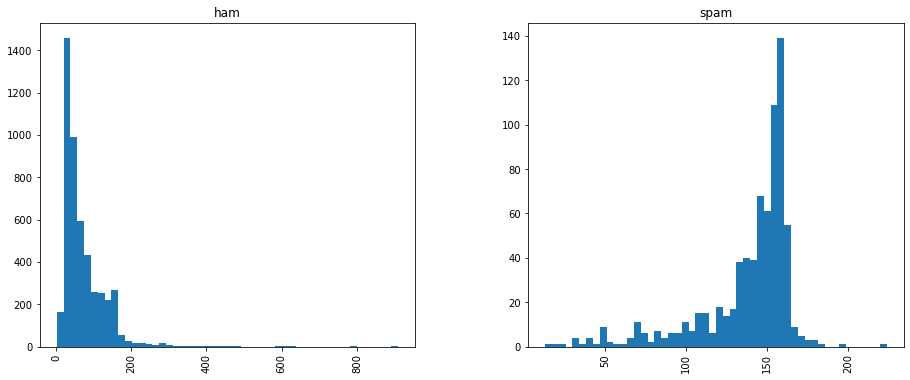

In [3]:
data['length'] = data['text'].apply(len)
ax = data.hist('length', by='class', bins=50, figsize=(15, 6))
# 스팸이 문장의 길이가 길다.

#### Tokenizing
##### process_text는 먼저 문장속에서 !,` 같은 punctuation을 삭제합니다.
##### 이후 stopwords를 삭제시킵니다.

##### Stopwords란 a, the, of, at 처럼 빈번하게 사용되는 단어들을  가르킵니다.>
##### Word frequency를 이용한 확률적 모델에는 이런 비번하게 사용되는 ##### 단어들에 특별한 의미가 없기 때문에 제거를 합니다

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ICT01_07\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [6]:
def process_text(text):
    
    # Remove Punctuations
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    nopunc = nopunc.strip()
    
    # Remove stopwords
    cleaned_words = [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return cleaned_words

data['text'].apply(process_text).head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

### Naive Bayes Model

In [7]:
vectering = CountVectorizer()
text = """I am a boy.
I am Tom.
You are Jane, Jane is so cool.
It is car
car is beautiful.
"""

import pandas as pd
text = pd.Series(text.split('\n'))
text

0                       I am a boy.
1                         I am Tom.
2    You are Jane, Jane is so cool.
3                         It is car
4                 car is beautiful.
5                                  
dtype: object

In [8]:
X = vectering.fit_transform(text)
X = X.toarray()
X

array([[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 1, 1, 0, 2, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

#### tf-idf(t, d) = tf(t, d) * idf(t)

- n is the total number of documents
- df(t) is the document frequency of t
- idf(t) = log [ (1 + n) / (1 + df(t)) ] + 1 (if smooth_idf=False)

In [11]:
def skTfIdf(tf):
    idf = np.log((1+tf.shape[0])/(1+tf.sum(0))) + 1
    # (n, p) = (n, p)*(p,)
    ret = tf*idf
    # return ret / np.linalg.norm(ret, axis=1, keepdims=True)
    return ret

In [12]:
np.linalg.norm(skTfIdf(X), axis=1, keepdims=True)

array([[2.91332291],
       [2.91332291],
       [6.03176615],
       [3.3045199 ],
       [3.3045199 ],
       [0.        ]])

In [13]:
skTfIdf(X)  

array([[1.84729786, 0.        , 0.        , 2.25276297, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [1.84729786, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        2.25276297, 0.        ],
       [0.        , 2.25276297, 0.        , 0.        , 0.        ,
        2.25276297, 1.55961579, 0.        , 3.69459572, 2.25276297,
        0.        , 2.25276297],
       [0.        , 0.        , 0.        , 0.        , 1.84729786,
        0.        , 1.55961579, 2.25276297, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 2.25276297, 0.        , 1.84729786,
        0.        , 1.55961579, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ,

In [14]:
skTfIdf(X) / np.sqrt((skTfIdf(X)*skTfIdf(X)).sum(1, keepdims=True))

<ipython-input-14-ca3937828106>:1: RuntimeWarning: invalid value encountered in true_divide
  skTfIdf(X) / np.sqrt((skTfIdf(X)*skTfIdf(X)).sum(1, keepdims=True))


array([[0.6340862 , 0.        , 0.        , 0.77326237, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.6340862 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.77326237, 0.        ],
       [0.        , 0.37348314, 0.        , 0.        , 0.        ,
        0.37348314, 0.25856702, 0.        , 0.61252304, 0.37348314,
        0.        , 0.37348314],
       [0.        , 0.        , 0.        , 0.        , 0.55902156,
        0.        , 0.47196441, 0.68172171, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.68172171, 0.        , 0.55902156,
        0.        , 0.47196441, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,

#### TfidfTransformer(norm=u'l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

In [15]:
tfidf = TfidfTransformer()
Xtf = tfidf.fit_transform(X).toarray()
Xtf

array([[0.6340862 , 0.        , 0.        , 0.77326237, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.6340862 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.77326237, 0.        ],
       [0.        , 0.34341566, 0.        , 0.        , 0.        ,
        0.34341566, 0.23775092, 0.        , 0.68683131, 0.34341566,
        0.        , 0.34341566],
       [0.        , 0.        , 0.        , 0.        , 0.55902156,
        0.        , 0.47196441, 0.68172171, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.68172171, 0.        , 0.55902156,
        0.        , 0.47196441, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ,

In [16]:
(Xtf*Xtf).sum(1)

array([1., 1., 1., 1., 1., 0.])

In [17]:
pipeline = Pipeline([
    ('vectorization', CountVectorizer(analyzer=process_text)),  # Convert strings to frequency vectors
    ('tfidf', TfidfTransformer()),  # Convert vectors to weighted TF-IDF scores
    ('classifier', MultinomialNB())
])

#### Normalize의 의미 : 각 문서별로 문서의 길이를 정규화 시키는 방법이다.

In [18]:
tfs = np.array([[0, 0, 2],
                [12, 27, 3]])

In [19]:
normedTfs = tfs / np.sqrt((tfs*tfs).sum(1, keepdims=True))
normedTfs

array([[0.        , 0.        , 1.        ],
       [0.40406102, 0.90913729, 0.10101525]])

In [20]:
np.sum(normedTfs * normedTfs, axis=1)

array([1., 1.])

In [21]:
train_x, test_x, train_y, test_y = train_test_split(data['text'], data['class'], test_size=0.2)
pipeline.fit(train_x, train_y)

Pipeline(steps=[('vectorization',
                 CountVectorizer(analyzer=<function process_text at 0x000001C0836253A0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98       959
        spam       1.00      0.69      0.81       156

    accuracy                           0.96      1115
   macro avg       0.98      0.84      0.89      1115
weighted avg       0.96      0.96      0.95      1115



<AxesSubplot:>

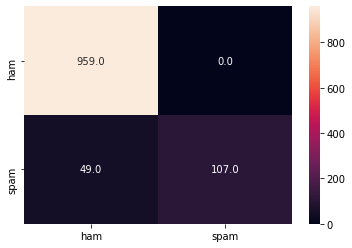

In [22]:
pred_y = pipeline.predict(test_x)

print(classification_report(test_y, pred_y))
className = pipeline.steps[2][1].classes_
sns.heatmap(confusion_matrix(test_y, pred_y), fmt='.1f', annot=True, 
            xticklabels=className, yticklabels=className)